## Defines and imports

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

#!apt-get -y install python-pil
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
#import PIL.image

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up python-apt (1.4.0~beta3build2) ...
Setting up python3-dbus (1.2.4-1buil

    100% |████████████████████████████████| 7.0MB 167kB/s 


In [0]:
from __future__ import print_function
import collections
import h5py, pickle, sys, os, gzip
import numpy as np


import torch
from torch.autograd import Variable
from torch.nn import functional as F

def fg_color(color):
    r,g,b = color
    color = 16 + (r * 36) + (g * 6) + b
    return '38;5;%dm' % color

def bg_color(color):
    r,g,b = color
    color = 16 + (r * 36) + (g * 6) + b
    return '48;5;%dm' % color

def cprint2(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    print("\033[%s%s%s\033[0m" % (pre_code, fg_color(color), text), **kwargs)

def cprint3(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    print("\033[%s%s%s\033[0m" % (pre_code, bg_color(color), text), **kwargs)

from matplotlib import cm
def view_image(x, max=-1, min=-1):
    if len(x.shape) == 3:
        return view_imagec(x)
        
    print(x.shape)
    if max == -1:
        x1 = x.max()
    else:
        x1 = max

    if min == -1:
        x0 = x.min()
    else:
        x0 = min

    xn = (x - x0)/(x1 - x0 + 1e-3)
    xn = np.asarray(xn*256,dtype=np.int)
    for r in range(x.shape[0]):
        for c in range(x.shape[1]):
            v = int(xn[r,c])
            c = cm.jet(v)
            color = (int(c[0]*5), int(c[1]*5), int(c[2]*5))
            cprint3( color, ' ', end='')
        print('')


def view_imagec(x):   
    for r in range(x.shape[1]):
        for c in range(x.shape[2]):
            c = x[:,r,c]            
            color = (int(c[0]*5), int(c[1]*5), int(c[2]*5))
            cprint3( color, ' ', end='')
        print('')


# ----------------------------------------------------------------------------------------------------------------------
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


# ----------------------------------------------------------------------------------------------------------------------
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()



# ----------------------------------------------------------------------------------------------------------------------
def save_list_array(list, filename):
    with h5py.File(filename, 'w') as hf:
        for i in range(len(list)):
            if isinstance(list[i], np.ndarray):
                hf.create_dataset('_array_%d' % i, data=list[i])
            else:
                hf.create_dataset('_array_%d' % i, data=list[i].get_value())

from collections import defaultdict, OrderedDict
def table2dict_id_data(table):
    b2a = OrderedDict()
    a2b = defaultdict(list)
    for a, b in table:
        b2a[b] = a
        a2b[a].append(b)
    return a2b, b2a

def table2dict_data_id(table):
    b2a = OrderedDict()
    a2b = defaultdict(list)
    for b, a in table:
        b2a[b] = a
        a2b[a].append(b)
    return a2b, b2a


def eval_cos_distance(x1, x2):
    x1n = np.linalg.norm(x1, axis=1).reshape(-1, 1)
    x2n = np.linalg.norm(x2, axis=1).reshape(-1, 1)
    return np.dot(x1, x2.T) / np.dot(x1n, x2n.T)

def eval_square_distance(x1, x2):
    return -np.mean((x1 - x2)**2)

def eval_square_norm_distance(x1, x2):
    x1 = x1/np.linalg.norm(x1, 2)
    x2 = x2/np.linalg.norm(x2, 2)
    return -np.mean((x1 - x2)**2)



# ----------------------------------------------------------------------------------------------------------------------
def load_list_array(list, filename):
    with h5py.File(filename, 'r') as hf:
        # print('List of items in the base directory:', hf.items())
        for i in range(len(list)):
            if isinstance(list[i], np.ndarray):
                list[i] = np.array(hf.get('_array_%d' % i))
            else:
                list[i].set_value(np.array(hf.get('_array_%d' % i)))


# ----------------------------------------------------------------------------------------------------------------------
#def save_obj(obj, filename):
#    with open(filename, 'w') as f:
#        pickle.dump(obj, f, protocol=2)


# ----------------------------------------------------------------------------------------------------------------------
#def load_obj(filename):
#    with open(filename, 'r') as f:
#        return pickle.load(f)

def save_obj(obj, file):
    if not isinstance(file,str):
        pickle.dump(obj, file, protocol=2)
        return

    root,ext = os.path.splitext(file)
    if ext == '.gz':
        with gzip.open(file, 'w') as f:
            pickle.dump(obj, f, protocol=2)
    else:
        with open(file, 'w') as f:
            pickle.dump(obj, f, protocol=2)

# ----------------------------------------------------------------------------------------------------------------------
def load_obj(file):
    if not isinstance(file,str):
        return pickle.load(f)

    root,ext = os.path.splitext(file)
    if ext == '.gz':
        with gzip.open(file, 'r') as f:
            return pickle.load(f)
    else:
        with open(file, 'r') as f:
            return pickle.load(f)

# ----------------------------------------------------------------------------------------------------------------------
def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return (nb_samples + (-nb_samples % batch_size)) / batch_size  # roundup division
    else:
        return nb_samples / batch_size


# ----------------------------------------------------------------------------------------------------------------------
def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(nb_samples)
    for i in range(get_num_batches(nb_samples, batch_size, roundup)):
        yield ind[i * batch_size: (i + 1) * batch_size]

# ----------------------------------------------------------------------------------------------------------------------
def generate_ind_batch_loop(nb_samples, batch_size, random=True, roundup=True):
    while(True):
        for ind in generate_ind_batch(nb_samples, batch_size, random, roundup):
            yield ind
        print('gen reset')

# ----------------------------------------------------------------------------------------------------------------------
def one_hot(y, nb_classes):
    nb_samples = y.shape[0]
    Y = np.zeros((nb_samples, nb_classes))
    Y[np.arange(nb_samples), y] = 1
    return Y


def flip_ndarray(x, chanel_left=True):
    flip = np.random.randint(2, size=x.shape[0])
    y = np.copy(x)
    for n in range(x.shape[0]):
        if flip[n] == 1:
            if chanel_left:
                y[n, :, :, :] = y[n,: , :, ::-1]  # (n, c, y, x)
            else:
                y[n, :, :, :] = y[n, :, ::-1, :]  # (n, y, x, c)
    return y


def crop_ndarray(x, pad=1, chanel_left=True):
    pad_nx = np.random.randint(2 * pad + 1, size=x.shape[0])
    pad_ny = np.random.randint(2 * pad + 1, size=x.shape[0])
    y = np.copy(x)
    if chanel_left:  # (n, c, x, y)
        for n in range(x.shape[0]):
            for c in range(x.shape[1]):
                x_pad = np.pad(x[n, c], pad_width=((pad, pad), (pad, pad)), mode='constant')
                y[n, c, :, :] = x_pad[pad_nx[n]:pad_nx[n] + x.shape[2], pad_ny[n]:pad_ny[n] + x.shape[3]]
    else:  # (n, x, y, c)
        for n in range(x.shape[0]):
            for c in range(x.shape[3]):
                x_pad = np.pad(x[n, :, :, c], pad_width=((pad, pad), (pad, pad)), mode='constant')
                y[n, :, :, c] = x_pad[pad_nx[n]:pad_nx[n] + x.shape[1], pad_ny[n]:pad_ny[n] + x.shape[2]]
    return y


# ----------------------------------------------------------------------------------------------------------------------
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):        
            v = torch.from_numpy(v)
        
        if not v.is_cuda and cuda:
            v = v.cuda()
          
        if not isinstance(v, Variable):            
            v = Variable(v, volatile=volatile)
            
        out.append(v)
    return out
    
# ----------------------------------------------------------------------------------------------------------------------
def tanh(x):
    return F.tanh(x)

def relu(x):
    return F.relu(x)

def lrelu(x):
    return F.leaky_relu(x)

def sigmoid(x):
    return F.sigmoid(x)


# ----------------------------------------------------------------------------------------------------------------------
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):        
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({    
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr'] 
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch


## Model

In [0]:
from __future__ import print_function
from __future__ import division
import torch
import torch.backends.cudnn as cudnn

from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

torch.manual_seed(1)
torch.cuda.manual_seed(1)

!mkdir model
!mkdir results

class BetaVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(BetaVAE, self).__init__()
        self.input_dim = input_dim

        self.conv1 = nn.Conv2d(1,   64, kernel_size=4, padding=1, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2)
        self.fc3 = nn.Linear(7 * 7 * 128, 1024)
        self.fc41 = nn.Linear(1024, latent_dim)  # mu
        self.fc42 = nn.Linear(1024, latent_dim)  # log(psi)
        
        self.fc5 = nn.Linear(latent_dim, 1024)
        self.fc6 = nn.Linear(1024, 7 * 7 * 128)
        self.conv7 = nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2)
        self.conv8 = nn.ConvTranspose2d(64,   1, kernel_size=4, padding=1, stride=2)

    def encode(self, x):
        x = self.conv1(x)
        x = lrelu(x)
        x = self.conv2(x)
        x = lrelu(x)
        x = x.view(-1, 7 * 7 * 128)
        x = self.fc3(x)
        x = lrelu(x)
        h = x
        return self.fc41(h), self.fc42(h)

    def reparameterize(self, mu, logpsi):
        if self.training:
            std = logpsi.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.fc5(z)
        x = lrelu(x)
        x = self.fc6(x)
        x = lrelu(x)
        x = x.view(-1, 128, 7, 7)
        x = self.conv7(x)
        x = lrelu(x)
        h = x
        x = self.conv8(x)
        return sigmoid(x), h

    def forward(self, x):
        mu, logpsi = self.encode(x)
        z = self.reparameterize(mu, logpsi)
        #print(z.shape)
        y, h = self.decode(z)
        return y, mu, logpsi, h


def BCE_KLD_cost(x, mu, logpsi, Beta, y):
    BCE = F.binary_cross_entropy(x, y, size_average=False)
    KLD = -0.5 * torch.sum(1 + logpsi - mu.pow(2) - logpsi.exp())   # https://arxiv.org/abs/1312.6114 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return BCE + Beta*KLD


class Net(BaseNet):
    def __init__(self,  input_dim, latent_dim=20, Beta=1, lr=1e-3):
        super(Net, self).__init__()
        cprint('y', '  VAE')
        self.input_dim = input_dim
        self.lr = lr
        self.schedule = None #[] #[50,200,400,600]
        self.latent_dim = latent_dim
        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.Beta = Beta

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = BetaVAE(self.input_dim, self.latent_dim).cuda()
        cudnn.benchmark = True
        
        self.J = BCE_KLD_cost

        print('    Total params: %.2fM' % ( self.get_nb_parameters() / 1000000.0) )

    def create_opt(self):
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9, weight_decay=5e-4)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        #self.optimizer = AdamW(self.model.parameters(), lr=self.lr, weight_decay=5e-2)
        #self.optimizer = SGDW(self.model.parameters(), lr=self.lr, weight_decay=5e-3, momentum=0.9, nesterov=True)

    def fit(self, x):
        x, = to_variable(var=(x,) )
        
        self.optimizer.zero_grad()
        out, mu, logpsi, _ = self.model(x)

        loss = self.J(out, mu, logpsi, self.Beta, x)

        loss.backward()
        self.optimizer.step()

        return loss.data[0] / len(x)


    def eval(self, x, train=False):
        x, = to_variable(var=(x,), volatile=True)
        out, mu, logpsi, _ = self.model(x)
        loss = self.J(out, mu, logpsi, self.Beta, x)
        return loss.data[0] / len(x)

    def predict(self, x, train=False):
        x, = to_variable(var=(x,), volatile=True)
        out, _, _, _ = self.model(x)
        return out.data

    def extract(self, x, train=False):
        x, = to_variable(var=(x,), volatile=True)
        mu, logpsi = self.model.encode(x)
        z = self.model.reparameterize(mu, logpsi)
        return z.data

    def decode(self, z, train=False):
        z, = to_variable(var=(z,), volatile=True)
        out, _ = self.model.decode(z)
        return out.data



## RUN


Data:

Network:

Net:
  VAE
    Total params: 13.18M

Train:
  init cost variables:
it 0/15, Jtr = 188.339309,    time: 14.858300 seconds



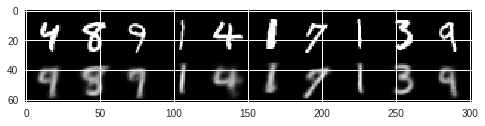

    Jdev = 160.127280 (inf)

Writting model/theta_best.dat

Writting model/theta_last.dat



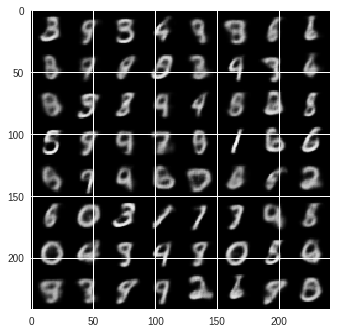

it 1/15, Jtr = 161.902186,    time: 14.877346 seconds



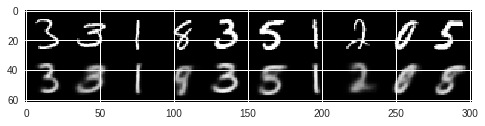

    Jdev = 143.071915 (160.127280)

Writting model/theta_best.dat

Writting model/theta_last.dat



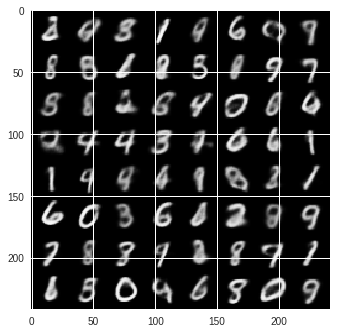

it 2/15, Jtr = 157.625095,    time: 14.834003 seconds



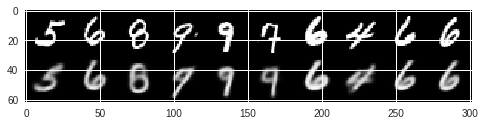

    Jdev = 144.474620 (143.071915)

Writting model/theta_last.dat



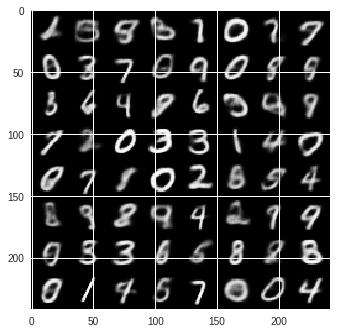

it 3/15, Jtr = 155.397524,    time: 14.836776 seconds



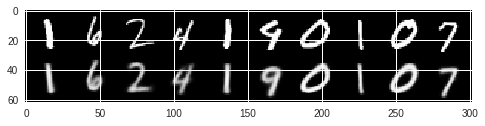

    Jdev = 139.589469 (143.071915)

Writting model/theta_best.dat

Writting model/theta_last.dat



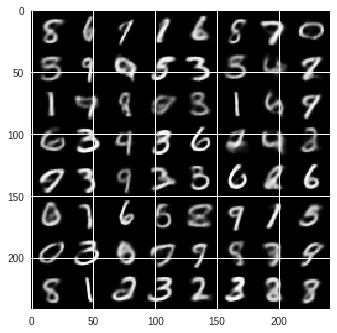

it 4/15, Jtr = 154.160751,    time: 14.841828 seconds



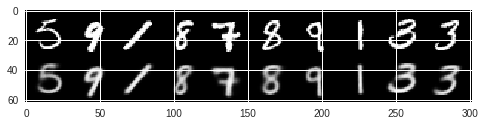

    Jdev = 137.903854 (139.589469)

Writting model/theta_best.dat

Writting model/theta_last.dat



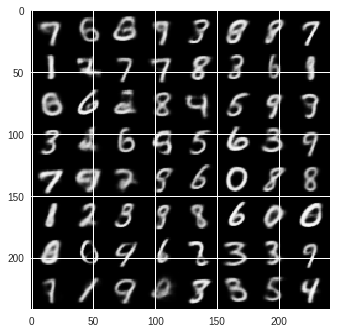

it 5/15, Jtr = 153.365988,    time: 14.825053 seconds



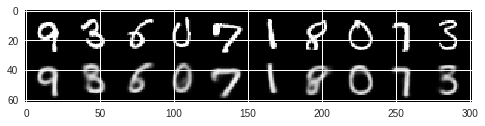

    Jdev = 135.137583 (137.903854)

Writting model/theta_best.dat

Writting model/theta_last.dat



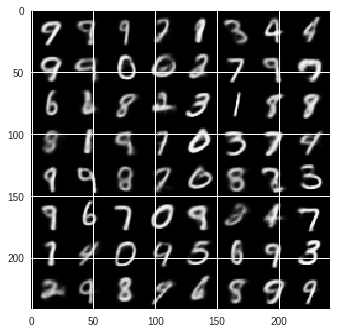

it 6/15, Jtr = 152.544414,    time: 14.828999 seconds



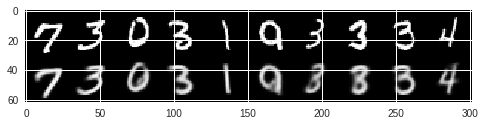

    Jdev = 135.883095 (135.137583)

Writting model/theta_last.dat



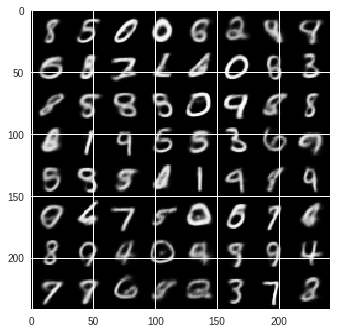

it 7/15, Jtr = 152.017397,    time: 14.801823 seconds



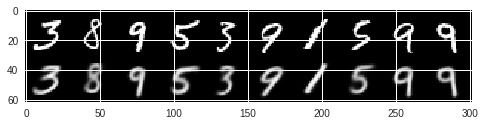

    Jdev = 135.524244 (135.137583)

Writting model/theta_last.dat



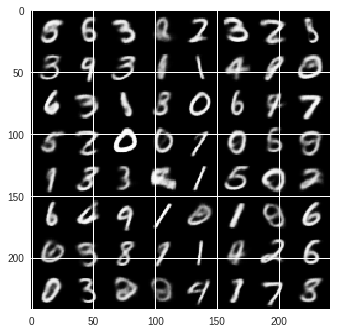

it 8/15, Jtr = 151.502019,    time: 14.797821 seconds



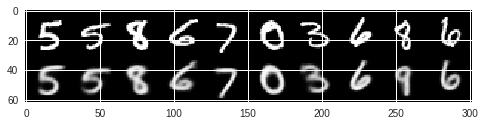

    Jdev = 134.977541 (135.137583)

Writting model/theta_best.dat

Writting model/theta_last.dat



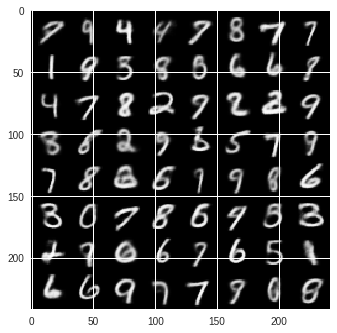

it 9/15, Jtr = 151.240812,    time: 14.808041 seconds



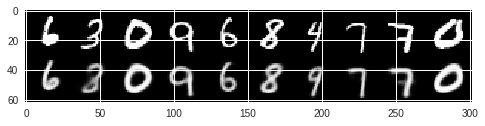

    Jdev = 134.669602 (134.977541)

Writting model/theta_best.dat

Writting model/theta_last.dat



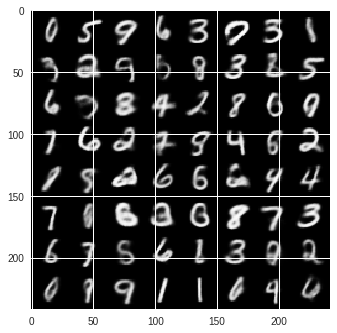

it 10/15, Jtr = 150.970483,    time: 14.772823 seconds



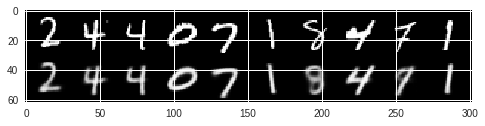

    Jdev = 134.763628 (134.669602)

Writting model/theta_last.dat



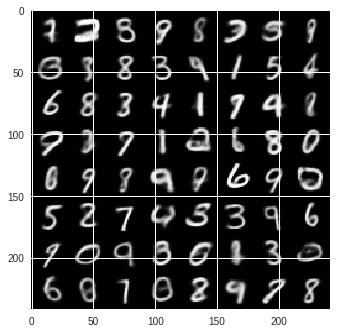

it 11/15, Jtr = 150.625520,    time: 14.846946 seconds



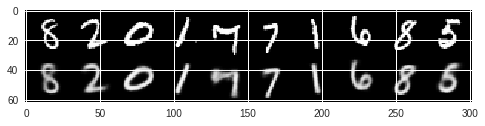

    Jdev = 134.800497 (134.669602)

Writting model/theta_last.dat



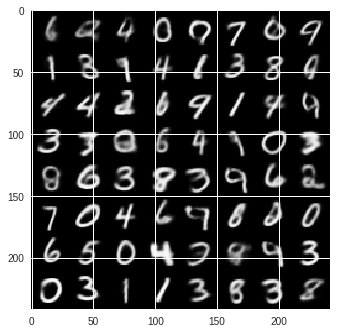

it 12/15, Jtr = 150.230669,    time: 14.807442 seconds



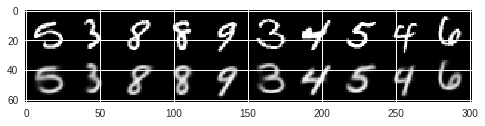

    Jdev = 133.727360 (134.669602)

Writting model/theta_best.dat

Writting model/theta_last.dat



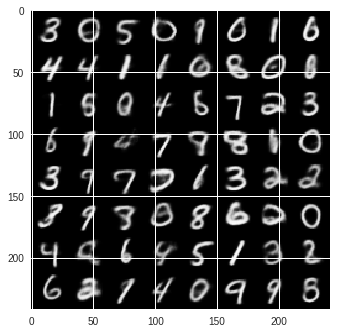

it 13/15, Jtr = 150.016101,    time: 14.851144 seconds



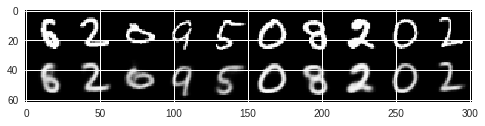

    Jdev = 133.738256 (133.727360)

Writting model/theta_last.dat



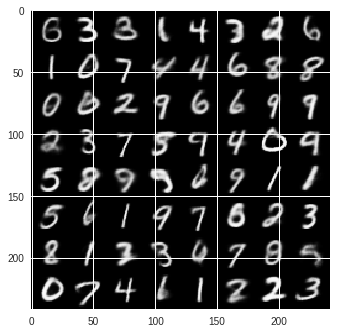

it 14/15, Jtr = 149.865194,    time: 14.813725 seconds



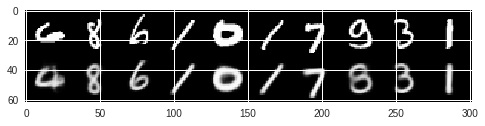

    Jdev = 133.855993 (133.727360)

Writting model/theta_last.dat



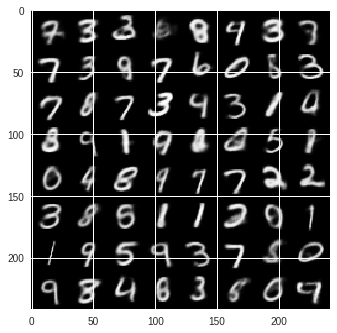

   average time: 17.756736 seconds


RESULTS:
  best_cost_dev: 133.727360
  best_cost_train: 149.865194
  nb_parameters: 13179305 (12.57MB)



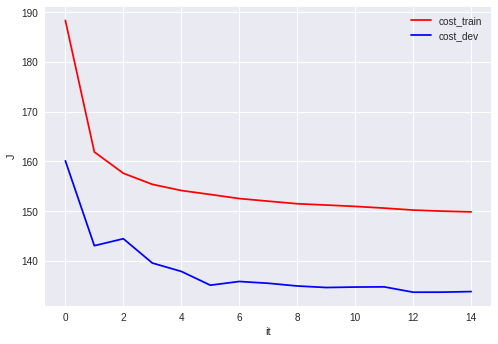

In [84]:
from __future__ import print_function
from __future__ import division
import torch, time
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------------------------------
# train config

batch_size = 128
nb_epochs = 15
log_interval = 10

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c','\nData:')

trainset = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)
     
testset = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())                                            
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)

input_dim = 784
latent_dim = 20

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c','\nNetwork:')

Beta = 5
net = Net(input_dim, latent_dim, Beta)

# try:
#     epoch = net.load('model/theta_last.dat')
# except:
#     epoch = 0
#     print('')
epoch = 0

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c','\nTrain:')

# try:
#     cost_train, cost_dev, best_cost = load_obj('model/cost.dat')

# except:
print('  init cost variables:')
cost_train = np.zeros(nb_epochs)
cost_dev = np.zeros(nb_epochs)
best_cost = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    net.set_mode_train(True)
    
    tic = time.time()   
    nb_samples = 0
    for x, y in trainloader:
        cost = net.fit(x)

        cost_train[i] += cost * len(x)
        nb_samples += len(x) 
        
    cost_train[i] /= nb_samples
    toc = time.time()

    # ---- print
    print("it %d/%d, Jtr = %f, " % (i, nb_epochs, cost_train[i]), end="")
    cprint('r','   time: %f seconds\n' % (toc - tic))
    net.update_lr(i)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(testloader):
            cost =  net.eval(x)

            cost_dev[i] += cost * len(x)
            nb_samples += len(x)
            
            # --- reconstruct           
            if j == 0:
                o = net.predict(x).cpu()
                save_image( torch.cat([x[:8], o[:8]]),'results/rec_%d.png' % i, nrow=8 )
                plt.figure()
                dd = make_grid(torch.cat([x[:10], o[:10]]), nrow=10).numpy()
                
                plt.imshow(np.transpose(dd, (1,2,0)), interpolation='nearest')
                plt.show()
                #view_image( make_grid(torch.cat([x[:3], o[:3]]), nrow=3).numpy() )
            
        cost_dev[i] /= nb_samples
     
        cprint('g','    Jdev = %f (%f)\n' % (cost_dev[i], best_cost))
        if cost_dev[i] < best_cost:
            best_cost = cost_dev[i]
            net.save('model/theta_best.dat')

    net.save('model/theta_last.dat')
    save_obj([cost_train, cost_dev, best_cost], 'model/cost.dat')
    
    # --- sample
    z = torch.randn(64, latent_dim)
    o = net.decode(z).cpu()
    save_image(o, 'results/sample_%d.png' % i)
    
    plt.figure()
    onp = make_grid( o ).numpy()
    plt.imshow(np.transpose(onp, (1,2,0)), interpolation='nearest')
    plt.show()
    #view_image( make_grid( o[:3] ).numpy() )
            

toc0 = time.time()
runtime_per_it =  (toc0 - tic0)/float(nb_epochs)
cprint('r','   average time: %f seconds\n' % runtime_per_it)


## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c','\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min( cost_dev )
best_cost_train = np.min( cost_train )

print('  best_cost_dev: %f' %  best_cost_dev)
print('  best_cost_train: %f' %  best_cost_train)
print('  nb_parameters: %d (%s)\n' % (nb_parameters, humansize(nb_parameters)))

with open('results/results.txt','w') as f:
    f.write('%f %f %d %s %f\n' % (best_cost_dev, best_cost_train, nb_parameters, humansize(nb_parameters), runtime_per_it))

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cost_train, 'r')
plt.plot(cost_dev[::nb_its_dev], 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('J')
plt.xlabel('it')
plt.grid(True)
plt.savefig('results/train_cost.png')


In [0]:
from google.colab import files

## Plots and results


Data:

Network:

Net:
  VAE
    Total params: 13.18M
Reading model/theta_best.dat

  restoring epoch: 13, lr: 0.001000

Train:

Extract:


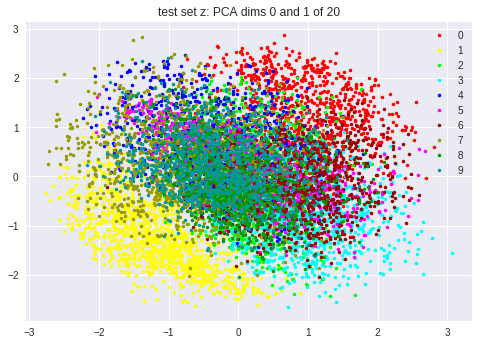

In [90]:
from __future__ import division


batch_size = 128

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c','\nData:')

input_dim = 784

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c','\nNetwork:')

net = Net(input_dim, latent_dim, Beta)


epoch = net.load('model/theta_best.dat')
cost_train, cost_dev, best_cost = load_obj('model/cost.dat')

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c','\nTrain:')

# train
cprint('c','\nExtract:')

rec_ims = []
dec_z = []
y = []

net.set_mode_train(False)

for j, (x, y_l) in enumerate(testloader):
# --- reconstruct           
    o = net.predict(x).cpu().numpy()
    z = net.extract(x).cpu().numpy()
    
    rec_ims.append(o)
    dec_z.append(z)
    y.append(y_l.numpy())
    
rec_ims = np.concatenate(rec_ims)
dec_z = np.concatenate(dec_z)
y_dev = np.concatenate(y)


Nclasses = np.max(y_dev)+1

################################################
shrink_factor = 1  # no data loss
###############################################

y_dev = y_dev[0::shrink_factor]
rec_ims = rec_ims[0::shrink_factor]
dec_z = dec_z[0::shrink_factor]


ndim = (dec_z.shape[1])
## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its
import matplotlib
import matplotlib.pyplot as plt

c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']

## PCA PLOTS of e ------------------------------------------------------------------------------------------
from matplotlib.mlab import PCA

pca_transform = PCA(dec_z, standardize=False)

dec_z_pca = pca_transform.Y

plt.figure()
for i in range(Nclasses):
    assignments = (y_dev == i)
    plt.plot(dec_z_pca[assignments, 0], dec_z_pca[assignments, 1], '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
plt.title('test set z: PCA dims 0 and 1 of %d' % ndim)
plt.grid(True)
plt.savefig('results/z_test.png')
plt.show() 

files.download('results/z_test.png')


Data:

Network:

Net:
  VAE
    Total params: 13.18M
Reading model/theta_best.dat

  restoring epoch: 13, lr: 0.001000

Train:

Extract:
checking shapes: X, assignments
1000
1000
Computing t-SNE embedding
Npoints = 1000, Ndims = 20
embdeddings computed


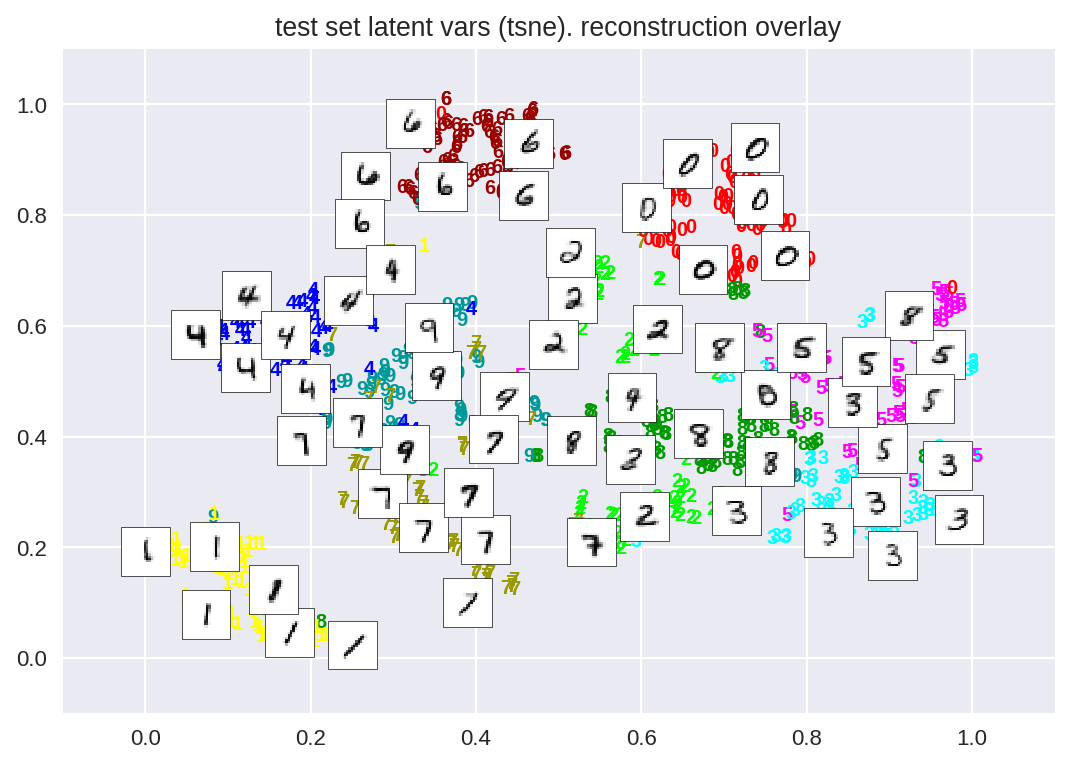

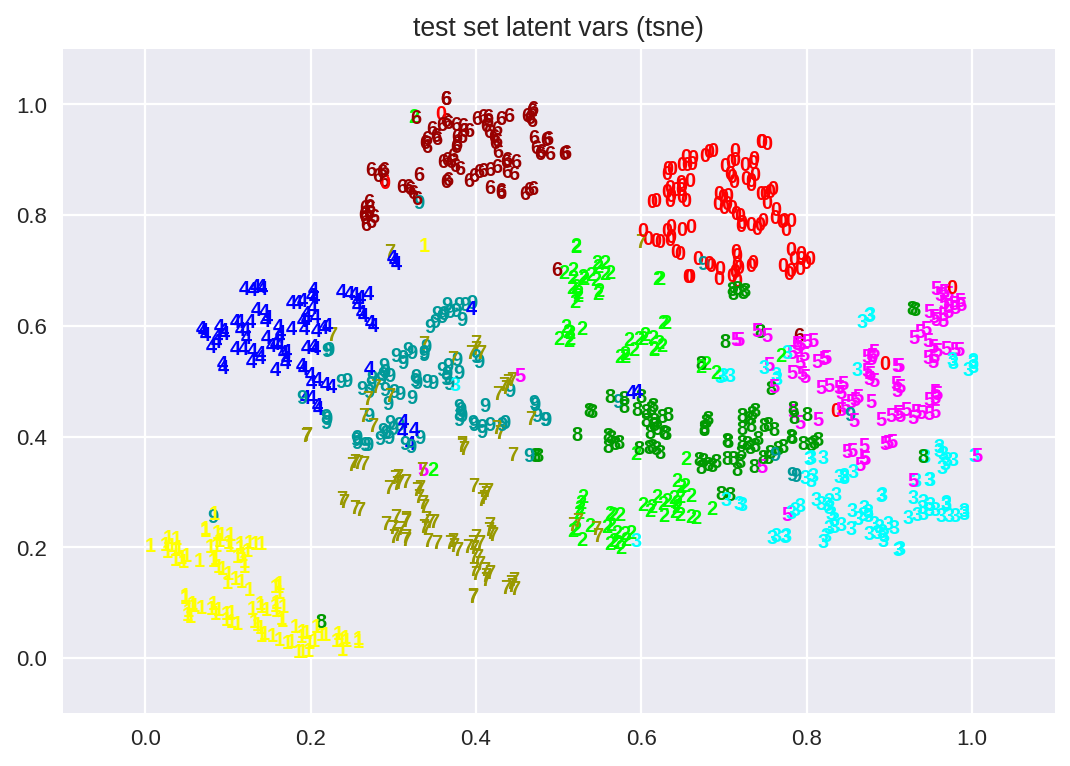

In [87]:
# TSNE / PCA plots with overlays

from time import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from __future__ import print_function
from __future__ import division
import time, sys

import torch.utils.data as data
import torchvision.transforms as transforms

def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def plot_vertical_conv_embeddings(X, y, imgs, centers=None, title=None, overlay_ims=True, savefile=None):
  # X  (batch_size,2)
  # y (batch_size)
  # imgs (batch_size, size1, size2)
  
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    plt.figure(dpi=160)
    ax = plt.subplot(111)
    
    if centers is not None:
        centers = (centers - x_min) / (x_max - x_min)
        #for i in range(centers.shape[0]):
        plt.plot(centers[:,0], centers[:,1], 'ok', zorder=10)
        

    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=c[y[i]],
                 fontdict={'weight': 'bold', 'size': 9})
    

    if hasattr(offsetbox, 'AnnotationBbox') and overlay_ims:
        shuffle_in_unison_scary(X, imgs)
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-4 * imgs.shape[1]:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(imgs[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)

    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])  
    #plt.xticks([]), plt.yticks([])
    plt.grid(True)
    if title is not None:
        plt.title(title)
    if savefile is not None:
      plt.savefig('./' + savefile)
################################# 


batch_size = 128

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c','\nData:')

input_dim = 784

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c','\nNetwork:')

net = Net(input_dim, latent_dim, Beta)


epoch = net.load('model/theta_best.dat')
cost_train, cost_dev, best_cost = load_obj('model/cost.dat')

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c','\nTrain:')

# train
cprint('c','\nExtract:')

rec_ims = []
dec_z = []
y = []

net.set_mode_train(False)

for j, (x, y_l) in enumerate(testloader):
# --- reconstruct           
    o = net.predict(x).cpu().numpy()
    z = net.extract(x).cpu().numpy()
    
    rec_ims.append(o)
    dec_z.append(z)
    y.append(y_l.numpy())
    
rec_ims = np.concatenate(rec_ims)
dec_z = np.concatenate(dec_z)
y_dev_f = np.concatenate(y)


Nclasses = np.max(y_dev)+1

ndim = (dec_z.shape[1])

y_dev = y_dev_f
x_dev = rec_ims
e1_dev = dec_z


## ---------------------------------------------------------------------------------------------------------------

shrink_factor = 10
picture_downsample = 2
Npixels = 1

x_dev = x_dev.squeeze(1)
x_dev = x_dev[0::shrink_factor, :, :]
e1_dev = np.reshape(e1_dev, (y_dev.shape[0], Npixels, e1_dev.shape[1]), 'C')
e1_dev = e1_dev[0::shrink_factor, :, :]
e1_dev = np.reshape(e1_dev, (e1_dev.shape[0]*Npixels, -1), 'C')
y_dev = y_dev[0::shrink_factor]
#e2_dev = e2_dev[0::shrink_factor]
#centers2 = net.model.CU2.centers.cpu().numpy()
x_dev_ds = x_dev[:, 0::picture_downsample, 0::picture_downsample] #Downsample

# (Npixels, Nsamples)
assignments = np.tile(y_dev, (Npixels, 1))
assignments = assignments.reshape((Npixels * len(y_dev)), order='F')

expanded_ims = np.tile(x_dev_ds, (Npixels, 1, 1, 1))
#print(expanded_ims.shape)
expanded_ims = expanded_ims.reshape((Npixels * len(y_dev), x_dev_ds.shape[1], x_dev_ds.shape[2]), order='F')
#print(expanded_ims.shape)

#############################################################
print('checking shapes: X, assignments')
print(e1_dev.shape[0])
print(assignments.shape[0])
assert assignments.shape[0] == e1_dev.shape[0]

use_pca = False
use_tsne = True

if use_tsne:
    if e1_dev.shape[1]>2:
        from sklearn import (manifold, datasets, decomposition, ensemble,
                              discriminant_analysis, random_projection)
        print("Computing t-SNE embedding")

        tsne = manifold.TSNE(n_components=2, perplexity=10.0, learning_rate=150.0, n_iter=1500, init='pca', random_state=0)
        tnse_in = e1_dev

        print("Npoints = %d, Ndims = %d" % (tnse_in.shape[0], tnse_in.shape[1]))

        X_tsne = tsne.fit_transform(tnse_in)

    else:
        X_tsne = e1_dev

elif use_pca:
    X_tsne = pca_transform.project(e1_dev)[:,0:2]
else:
    X_tsne = e1_dev[:,0:2]

print('embdeddings computed')

######################### e_dev is 16 dimensional

plot_vertical_conv_embeddings(X_tsne, assignments, expanded_ims, centers=None, overlay_ims=True, title='test set latent vars (tsne). reconstruction overlay', savefile='tsne_overlay.png')
plot_vertical_conv_embeddings(X_tsne, assignments, expanded_ims, centers=None, overlay_ims=False, title='test set latent vars (tsne)', savefile='tsne_no_overlay.png')
#plot_vertical_conv_embeddings(X_tsne, assignments, expanded_ims, centers=centers_tsne, overlay_ims=True, title=None, savefile='pca_digits.png')

files.download('tsne_overlay.png')
files.download('tsne_no_overlay.png')

In [0]:
if latent_dim == 2:
  #latent_dim = 2
  net = Net(input_dim, latent_dim, Beta)

  epoch = net.load('model/theta_best.dat')
  cost_train, cost_dev, best_cost = load_obj('model/cost.dat')

  # --- sample
  #z = torch.randn(200, 20)

  stepdim = 25

  dim_range = np.linspace(-3, 3, stepdim)
  dimx, dimy = np.meshgrid(dim_range, dim_range)
  dim_mtx = np.concatenate((np.expand_dims(dimx,2), np.expand_dims(dimy,2)), axis = 2)

  print(dim_mtx.shape)

  z = torch.from_numpy(dim_mtx).type(torch.FloatTensor)
  z.view(stepdim**2, 2)
  #z = Variable(x.cuda())

  o = net.decode(z).cpu()

  plt.figure(dpi=160)
  onp = make_grid( o , nrow=stepdim).numpy()
  fig = plt.imshow(np.transpose(onp, (1,2,0)), interpolation='nearest')
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title('2d z manifold')
  plt.savefig('manifold.png')
  plt.show()

  files.download('manifold.png')


Net:
  VAE
    Total params: 13.18M
Reading model/theta_best.dat

  restoring epoch: 13, lr: 0.001000
correct target: 7
torch.Size([30, 1, 28, 28])


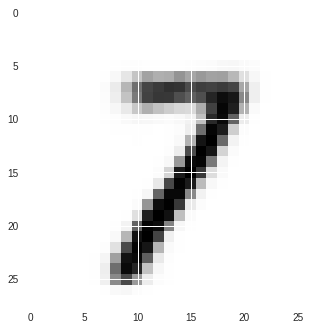

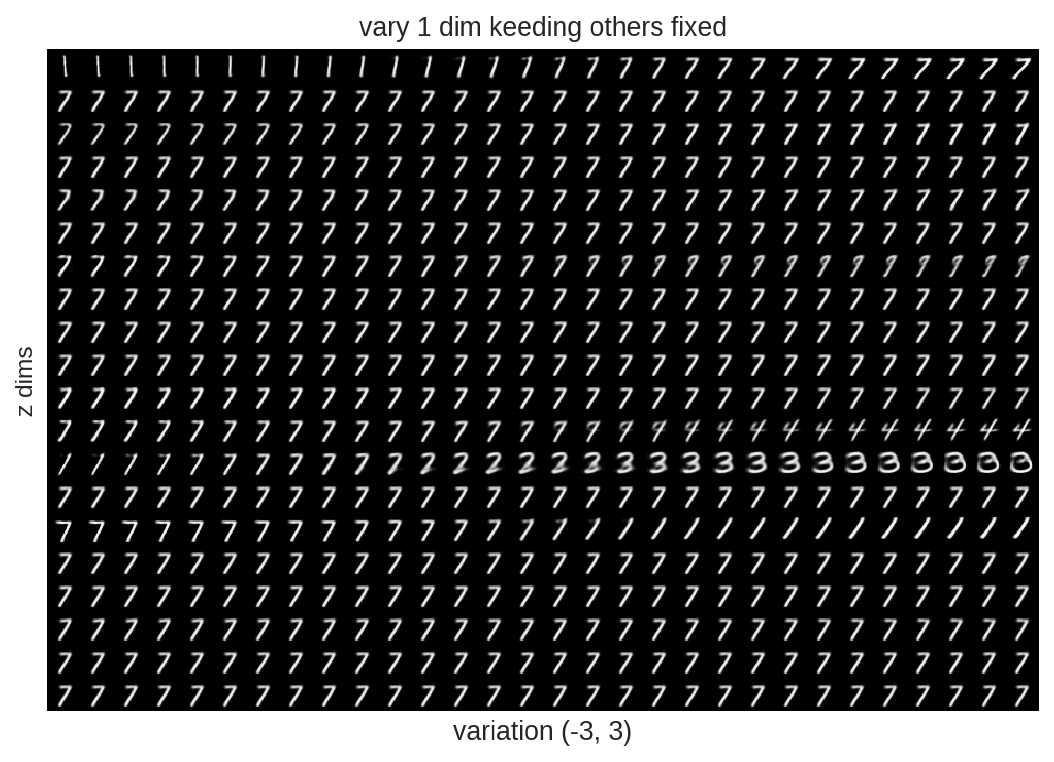

In [89]:
# Take digit, keep all dims except one fixed and vary that one in range

#latent_dim
net = Net(input_dim, latent_dim, Beta)

epoch = net.load('model/theta_best.dat')
cost_train, cost_dev, best_cost = load_obj('model/cost.dat')

# --- sample
#z = torch.randn(200, 20)

Nim = 0
plt.figure()
plt.imshow(rec_ims[Nim].reshape((28,28)))
plt.savefig('variation_original.png')
files.download('variation_original.png')

stepdim = 30

print('correct target: %d' % y_dev_f[Nim])

z_start = np.expand_dims(dec_z[Nim], 0)
dim_range = np.linspace(-3, 3, stepdim)


for i in range(latent_dim):
    
    expand_z = np.tile(z_start, (stepdim, 1))
    expand_z[:, i] = dim_range
    z_in = torch.from_numpy(expand_z).type(torch.FloatTensor)
    if i == 0:
        o = net.decode(z_in).cpu()
        print(o.shape)
    else:
        
        o = torch.cat((o,net.decode(z_in).cpu()), dim=0)


plt.figure(dpi=160)
onp = make_grid( o , nrow=stepdim).numpy()
fig = plt.imshow(np.transpose(onp, (1,2,0)), interpolation='nearest')
plt.xlabel('variation (-3, 3)', fontsize=12)
plt.ylabel('z dims')
# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_ticks([])
fig.axes.get_yaxis().set_ticks([])

plt.title('vary 1 dim keeding others fixed')
plt.savefig('dim_variation.png')
plt.show()


files.download('dim_variation.png')